<a id='Header'></a>

# Introduction to Bayesian Neural Networks in Edward

This tutorial is an introduction to Bayesian methods in Neural Networks, and should be an in-depth introduction to Bayesian inference methods and probabilistic modeling. Prior knowledge of basic probability theory is recommended before tackling all the concepts in this tutorial.

As can be seen in the [table of contents](#TOC), this tutorial first sets up the problem of Bayesian linear regression along with an introduction to Bayesian infererence. Then we illustrate an implementation of BLR in Edward, and then move onto an introduction to approximate inference methods. From there, we tackle an implementation of a convolutional Neural Network (CNN) trained on the MNIST digit dataset. If you are already familiar with inference and Bayesian statistics, and are more interested in the workings of Edward with neural nets, you can go directly to the example implementation in [section 3](#EdwardCNN). 

As for the code in this notebook, the primary python library used to model BNNs is [Edward](http://edwardlib.org), a tensorflow library designed for probablistic modeling, and most importantly, approximate Bayesian inference and modeling. Make sure tensorflow, numpy, edward, as well as matplotlib, is properly installed before using this notebook.  
  
_(Note: If you have a pretty old computer, using tensorflow 1.5 or below maybe advised since a "core dump: illegal instruction" error may occur when importing edward. Otherwise ignore this warning)_

Many thanks are given to Professor [Andrew Wilson](https://people.orie.cornell.edu/andrew/), who has both introduced and helped us understand many of the concepts written here.

<a id='TOC'></a>

# Table of contents

### [1. Bayesian Linear Regression](#Bayesian Linear Regression)

1.1 [Problem Setup: Simple Linear Regression](#BLR1)

1.2 [Introduction to Bayesian Inference](#BLR2)

1.3 [Implementing Bayesian Linear Regression](#BLR3)

###   [2. Approximate Inference](#ApproxInf)

2.1   [Limits of Exact Inference](#ApproxInf2)  

2.1.1 [Optional Read: Bayesian Model Comparison](#addApprox)

2.2 [Variational Inference](#ApproxInf3)

2.2 Markov Chain - Monte Carlo (MCMC) 

### [3. Bayesian Neural Network Example](#BNN)
    
3.1 [Bayesian Multilayer Perceptron](#BNN1)
  
3.2 [Bayesian Convolutional Neural Network](#BNN2)


In [1]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Another Note/warning: The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<a id='Bayesian Linear Regression'></a>
## 1. Bayesian Linear Regression


<a id='BLR1'></a>
### 1.1 Problem setup: simple linear regression
Let's first tackle simple linear regression. Simple linear regression is a regression model that models an unknown relationship between two scalar entities (denoted as $x$ and $y$) as a linear relationship such that $y_i$, an ith sample of $y$, can be written as $y_i = \beta x_i + \epsilon$.
More concretely, the linear regression problem is the following:

Given a dataset D with N data points:

$$ D = \{(x_i, y_i)\}_{i=1}^{N}$$ 

where x_i is the feature input for the ith data point and y the corresponding target value for the ith data point, find $\beta$ that minimizes the following objective:  

$$ \sum_i^N (y_i - \beta x_i)^2 $$  

This formulation commonly known as the __least squares problem__. What is also important is that the least-squares problem is mathematically equivalent to assuming the residual $y_i - \beta x_i$, corresponding to the noise term $\epsilon$, to be a _Gaussian white noise_. This noise has a mean at $\mu = 0 $  with variance $\sigma^2$, for all values of $i \in N$. Linear regression therefore also treats $y$ as a Gaussian random variable, centered about $\beta x$ and with variance $\sigma^2$. We can represent this information with the following notation:
$$ y \sim Normal(\beta x, \sigma^2)$$

To those interested in the math, one can derive the equivalence between the least squares objective and the Gaussian distributionby examining the __likelihood__ function for the Gaussian. Given the above expression of y, the likelihood function, a function that evaluates the probability of a given sample given our assumptions of the underlying mechanics, can be written as: 

$$ \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} )$$

This is simply the product of probability densities evaluated at each sample in the dataset. We can simply multiply the probabilities together because we consider each data point as being (conditionally) independent from each other. Our objective in linear regression to find $\beta$ such that this expression is maximized.

Maximizing this likelihood function is equivalent to maximizing the log of it, since $x$ and $\log x$ always increases/decreases together. Taking the log of the likelihood and simplifying the expression shows the implicit normality assumption in least-squares regression. For those interested, the derivation is done as the following:



Optimizing the above expression to obtain an estimate of $\beta$ above is an example of a __Maximum Likelihood Estimation(MLE)__ approach, or more generally speaking, a _frequentist_ approach. Frequentist approaches assume that there is enough data to conclude statistically significant conclusions about $\beta$ given the dataset, and produce a single point solution for $\beta$. This is often the approach taken for many conventional and widely adopted machine learning practices, but can be prone to overfitting when dataset is relatively small, or with increased complexity of the loss/likelihood functions - as is the case for neural networks - suffer from lack of interpretability.

[back to top](#Header)

$$ argmax_\beta \hspace{0.25cm}\prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} )$$
<br>
$$\iff argmax_\beta \hspace{0.25cm}\ln{ \big\{ \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} \big\} }$$

$$\iff argmax_\beta \hspace{0.25cm}\sum_{i=1}^N \big( -\ln{\sqrt{2\pi\sigma^2}} + \frac{-(y_i - \beta x_i)^2}{\sigma^2} \big\}$$
<br>
$$\iff argmax_\beta\hspace{0.25cm}\sum_{i=1}^N\frac{-(y_i - \beta x_i)^2}{\sigma^2}\hspace{3.3cm}$$
<br>
$$\iff  argmin_\beta \hspace{0.25cm}\sum_{i=1}^N (y_i - \beta x_i)^2\hspace{3.7cm}
$$

<a id='BLR2'></a>

### 1.2 Introduction to Bayesian Inference

_Bayesian_ approaches, on the other hand, avoid point estimations entirely. Rather, Bayesian method represent learned parameters - in the case for linear regression, the parameter $\beta$ - as probability distributions rather than single optimal solutions.  This works well for many statistical modeling scenarios, where data insufficiently represents true relationships and functions due to noise or incorrect data, and thus may require us to represent _uncertainty_ in learned parameters. 

This information on parameter uncertainties also provides prediction uncertainties, and can be incredibly useful for fields like deep learning, where model uncertainty has traditionally been poorly understood due to complexity of neural networks.


At the core of Bayesian methods lies the famous Bayes' Theorem, which can be written - in a more applicable form for probabilistic modeling - as the following:<br><br>

$$ P(Parameters \mid Data,Model) = \frac{P(Data \mid Parameters, Model) \cdot P(Parameters\mid Model)}{P(Data \mid Model)} $$
<br>
<br>
What makes Bayesian methods different is the addition of _prior belief_ to their models on the parameter being learned, which is represented as the second term on the numerator on the above expression as $P(Parameters \mid Model)$. When size of collected samples used to train statistical model is small, this prior will have relatively significant influence on the behavior of the models, but with growing size of dataset diminish in its effects.

The left side of this equation is what we aim to learn from the data, and what is called the _posterior distribution_ over the parameters, reflecting our beliefs on the parameter __after__ data has been observed. This posterior distribution can be further expanded as shown below:

_Note: model and parameters all represented as $\theta$ and data as D_
<br><br><br>
$$ Posterior \hspace{1cm}\iff\hspace{1cm}P(\theta \mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{
 P(D)} \hspace{1cm}\iff\hspace{1cm} P(\theta\mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{
\int P(D \mid \theta) \cdot P(\theta)\hspace{0.1cm}d\theta}$$
<br><br>
Notice that the first term on the numerator, $P(D \mid \theta)$ corresponds to the _likelihood_ of the data given model parameters, as we have already discussed in the previous section. Furthermore, the second term on the numerator corresponds to our prior beliefs on the parameter $\theta$, as explained above. What is interesting is the denominator. The conversion of $P(D)$ into the integral is  the sum rule and the product rule of Bayes' Theorem, which respectively states that <br><br>
$$P(x) \iff \int_{-\infty}^\infty{P(x \cap y)\hspace{0.1cm}dy} \hspace{3cm}P(x,y)\iff P(x\mid y)\cdot p(y)$$

The first one is called the sum rule because integrals are essentially summations, and is particularly important in Bayesian statistics because it allows functions with multiple unknown random variables to collapse to functions with less parameters, known as _marginal probability densities_. Here, the denominator for the posterior corresponds to a quantity called the _marginal likelihood_, where model parameters has been marginalized out using the sum rule. Therefore the above expression is also written as<br><br>
$$ \text{Posterior} \iff \frac{\text{Likelihood} \cdot \text{Prior} }{\text{Marginal Likelihood}} $$
<br>
  
The process of evaluating this expression, hence learning the parameters of a proposed statistical model, is called __inference__, and is the most important part of Bayesian modeling. What is particularly noteworthy is that if the integral for the marginal likelihood is solvable, the posterior distribution can be directly calculated without any estimations. The difficulty in Bayesian methods arise from models where the marginal likelihood cannot be directly evaluated, as will be fully explained in [section 2](#ApproxInf)

[back to top](#Header)

<a id='BLR3'></a>
### 1.3  Implementing Bayesian Linear Regression with Edward
Now that we have an idea of how Bayesian methods work, let's set up this inference model for simple linear regression to understand how we can implement inference with Edward. To do so, we simply need to set up the data, the likelihood function and set a prior distribution that represents prior beliefs.

__Data__:  
The dataset will be a generated dataset, obtained by the following data-generating function:
```python
import numpy as np
def toy_dataset(dataset_size, true_beta, noise_stdev):
    # an array of randomly sampled integers
    x = np.random.uniform(low=1, high = 20, size=dataset_size)
    # target variable y is first initialized to true_beta * x
    y = x * true_beta
    # noise is a random normal with zero mean and stdev
    noise = np.random.normal(scale = noise_stdev,size = dataset_size)
    y += noise
    return x,y
```

This dataset-generating function returns a uniformly sampled x, and y, which is the result of multiplying x by a constant and adding Gaussian noise. We then train test split a generated dataset with this code:
```python
# split data into train and test set
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(sample_data_x, sample_data_y, test_size = .2)
```
A plot of a sample dataset with 2000 data points - 1600 for train set and 400 for test -  made by this function is shown below:

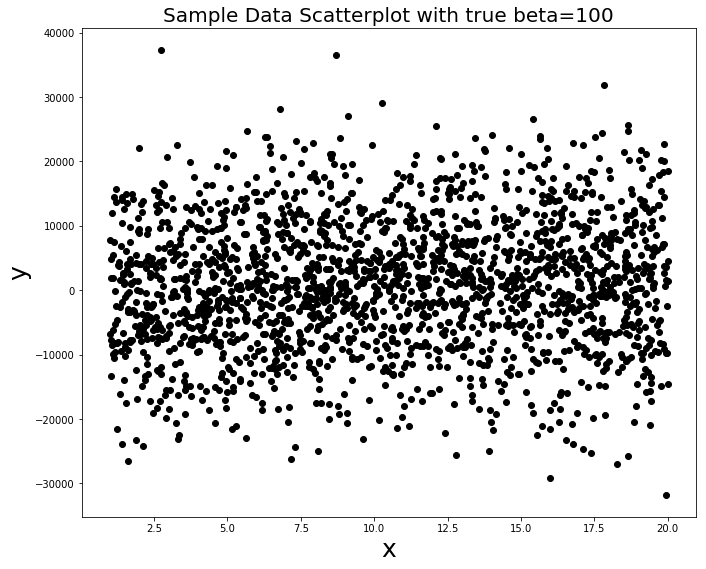

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
def toy_dataset(dataset_size, true_beta, noise_stdev):
    # an array of randomly sampled integers
    x = np.random.uniform(low=1, high = 20, size=dataset_size)
    
    # target variable y 
    y = x * true_beta
    
    # noise is a random normal with zero mean and stdev
    noise = np.random.normal(scale = noise_stdev,size = dataset_size)
    y += noise
    
    return x,y,true_beta, dataset_size

sample_data_x, sample_data_y, true_beta,dataset_size = toy_dataset(2000,100,10000)

# split data into train and test set
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(sample_data_x, sample_data_y, test_size = .995)

#plot the sample_data
fig = plt.figure(figsize=(11,9))
plt.scatter(sample_data_x,sample_data_y, c="black")
plt.title("Sample Data Scatterplot with true beta="+str(true_beta),fontsize=20)
plt.xlabel("x", fontsize=25)
plt.ylabel("y",fontsize=25)
plt.show()

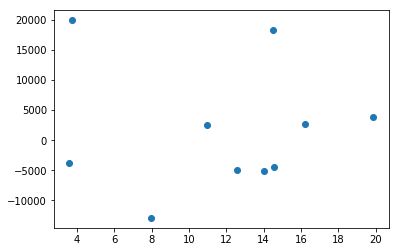

In [3]:
plt.scatter(train_x, train_y)
plt.show()

__Likelihood__:   
In the simple linear regression setting, for a given value of $\beta$, the likelihood of the data can be evaluated the following two ways:  
If we use the likelihood of a Gaussian, we use $ \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2} } exp(\frac{-(y_i - \beta x_i)^2}{\sigma^2} )$ and use some arbirary value of $\sigma^2$ 
<br> 

  
or using the equivalence of minimizing least squares with maximizing the likelihood of a Gaussian, we can also use $ -\sum_i^N (y_i - \beta x_i)^2 $  <br><br>

__Prior__:   
For this example, let's represent prior assumptions as a Gaussian with variance of 1 that is centered on a value that is different compared to the true $\beta$

We deliberately impose inaccurate prior beliefs, since this is more realistic, and will be illustrate the effectiveness of Bayesian methods even with incorrect priors. Also, keep in mind that if priors were really good and the parameter precisely known, there would be no need to do inference, or for that matter, model-based learning! 

<br>
Now we will actually implement this setup on Edward, as is illustrated in the code blocks shown below:<br><br>

```python
# Bayesian Linear Regression implementation in Edward
import tensorflow as tf
import edward as ed
from edward.models import Normal
import numpy as np
```
<br>
Remember to have all of these libraries installed. Here we import Normal. However, there are many types of random variables (any probability distribution you can think of is most likely in there) supported by Edward, so feel free to play around with these. We will learn in the next section that there are only certain types of random variables that allow exact Bayesian inference. However, Edward is aimed to do approximate inference, and thus can support a much wider variety of random variables.<br><br>

```python
# defining the tensor that will hold the feature input
X = tf.placeholder(tf.float32, shape=dataset_size)

# beta will have inaccurate prior initializations since prior is a relatively narrow Gaussian on the wrong integer
beta = Normal(loc=tf.constant(true_beta-5.0,shape=[1]),scale=tf.constant(100.0, shape=[1]))
y = Normal(loc=X*beta, scale=tf.ones(dataset_size))

# define the posterior
qbeta = Normal(loc=tf.get_variable("qbeta/loc", 1),
            scale=tf.nn.softplus(tf.get_variable("qbeta/scale", 1)))

```
<br>
The model used to instantiate the posterior determines the functional form of the _prior distribution_, which is the Gaussian/Normal distribution here. The loc, scale arguments each correspond to the mean $\mu$ and standard deviation $\sigma$ (and not the variance!) and can either be assigned manually as is done here or through some learned metafeatures derived from the data.<br><br>

```Python
# inference through minimizing the KL-divergence 
inference = ed.KLqp({beta:qbeta}, data ={X: train_x, y: train_y})
inference.run(n_samples=5, n_iter=1000)
inference.finalize()
```
<br>
It should be noted that KLqp() is an approximate Inference method, as opposed to _exact inference_, and moreover, Edward is __not__ a library used for exact inference. This is not a setback. In fact, most frequent use cases of inference, as will be explained in the next section, will require approximate inference.

```python
# sample from the posterior and visualize
fig = plt.figure(figsize=(11,9))
post = qbeta.sample(100000).eval()
plt.hist(post, bins = 500,normed=True)
plt.show()
```

 Shown below is the result of visualizing the posterior - through a normalized histogram constructed from samples - obtained by training the Bayesian Linear regression model.

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 500935840.000


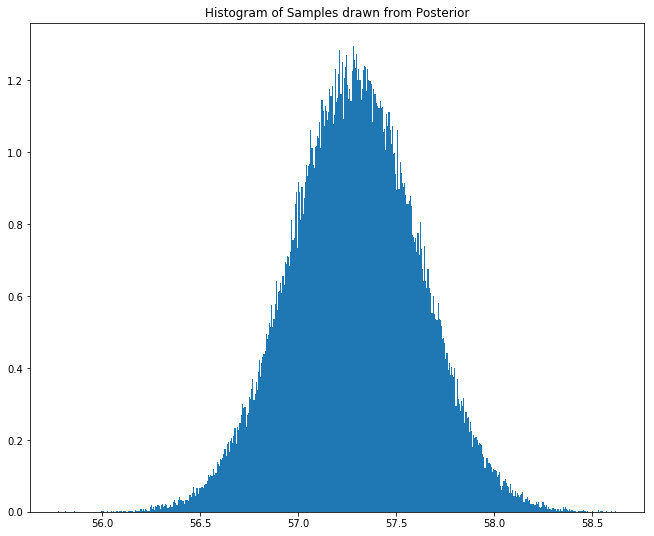

In [4]:
# Bayesian Linear Regression implementation in Edward
import tensorflow as tf
import edward as ed
from edward.models import Normal
import numpy as np

train_features = tf.placeholder(tf.float32, shape=train_x.shape)

# beta will have inaccurate prior initializations since prior is a relatively narrow Gaussian on the wrong integer
beta = Normal(loc=tf.constant(true_beta-5.0,shape=[1]),scale=tf.constant(100.0, shape=[1]))
target = Normal(loc=train_features*beta, scale=tf.ones(train_y.shape))

# define the posterior
qbeta = Normal(loc=tf.get_variable("qbeta/loc", 1),
            scale=tf.nn.softplus(tf.get_variable("qbeta/scale", 1)))

# inference through minimizing the KL-divergence 
inference = ed.KLqp({beta:qbeta}, data ={train_features: train_x, target: train_y})
inference.run(n_samples=5, n_iter=1000)
inference.finalize()


# sample from the posterior and visualize
fig = plt.figure(figsize=(11,9))
plt.title("Histogram of Samples drawn from Posterior")
post = qbeta.sample(100000).eval()
plt.hist(post, bins = 500,normed=True)
plt.show()

This shows that the inaccurate prior - centered at 5 with a fairly small standard deviation of 1 - does not cripple Bayesian methods at all, and that inferred posterior does a very good job approximating the true beta value. Let's compare to a point estimate of the true $\beta$ value obtained by running sklearn's linear regression module. Since our posterior distribution is a Gaussian, the point estimate and the peak of the inferred posterior above should be roughly the same. The code block used is as follows:

```python
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False)
lm.fit(sample_data_x.reshape(-1,1), sample_data_y.reshape(-1,1))
print(float(lm.coef_))
```

MLE estmate of true beta is: 103.48101463420804


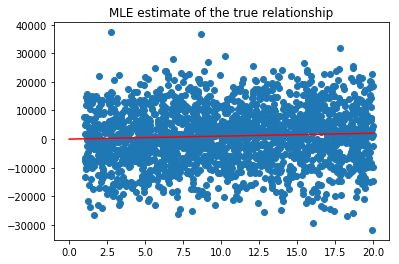

In [5]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False)
lm.fit(train_x.reshape(-1,1), train_y.reshape(-1,1))
print("MLE estmate of true beta is: "+str(float(lm.coef_)))

plt.scatter(test_x, test_y,)
temp = np.linspace(0,20,100)
plt.plot(temp, lm.coef_*temp.reshape(-1,1), c='red')
plt.title("MLE estimate of the true relationship")
plt.show()

This should illustrate that inference is a comparable technique to MLE techniques. Let's see how comparable the two approaches are in terms of prediction accuracy. The way you do it is to first construct a predictive distribution from the posterior distribution. The prediction distribution can be obtained as the following:

```python 
# first contruct the predictive distribution based on the inferred posterior distribution
test_features = tf.placeholder(tf.float32, shape=test_x.shape)
y_pred = Normal(loc=test_features * qbeta, scale=tf.ones(test_y.shape))
```
Here we define y_pred, which is the predictive distribution that uses the posterior qbeta as one of its inputs. Next, we compare it to the sklearn's linear regression model, and compare the mean squared error of both models:

```python

from sklearn.metrics import mean_squared_error
lm_pred = lm.predict(test_x.reshape(-1,1))
print("Mean squared error on test data for Bayesian model:")
print(ed.evaluate('mean_squared_error', data={test_features: test_x, y_pred:test_y}))

```
The print statements produced are as shown below:

In [6]:
# first contruct the predictive distribution based on the inferred posterior distribution
test_features = tf.placeholder(tf.float32, shape=test_x.shape)
y_pred = Normal(loc=test_features * qbeta, scale=tf.ones(test_y.shape))

print("Mean squared error on test data for Bayesian model:")
print(ed.evaluate('mean_squared_error', data={test_features: test_x, y_pred:test_y}))

# prediction accuracy for sklearn's linear regression module
from sklearn.metrics import mean_squared_error

lm_pred = lm.predict(test_x.reshape(-1,1))

print("\n"+"Mean squared error on test data for MLE model:")
print(mean_squared_error(test_y.reshape(-1,1), lm_pred))

Mean squared error on test data for Bayesian model:
98724300.0

Mean squared error on test data for MLE model:
98537466.62764302


Notice that the Bayesian linear regression model does slightly better, although not too significantly. This is expected because the best value of beta for the training set will most likely be slightly off due to difference in training and test data due to in-sample noise. Bayesian models capture this uncertainty and therefore should have better generalizations in their predictions across different samples.

<a id='ApproxInf'></a>

## 2. Approximate Bayesian Inference

In the sections presented so far, we've shown how inference can work for a relatively straightforward case of simple linear regression with a Normal prior and have demonstrated a working implementation in Edward. However, we previously observed that Edward implements an iterative algorithm - with a function called KLqp - that approximates, rather than analytically solve for the posterior distribution. What is the approximation technique used/available on Edward and why do we approximate to start with? 

To answer these questions, we first explain when approximate inference is necessary or recommended, ands introduce two popular branches of such approximate inference techniques: __Variational Inference (VI)__ and __Markov-Chain-Monte-Carlo (MCMC)__.



<a id='ApproxInf2'></a>

### 2.1 Limits of Exact Inference

Previously we explained that to do exact inference for the posterior, we evaluate the Bayes' formula:<br><br>

$$\frac{P(D \mid \theta) \cdot P(\theta)}{
\int P(D \mid \theta) \cdot P(\theta)\hspace{0.1cm}d\theta} \hspace{.5cm} \iff \hspace{.75cm} \frac{\text{Likelihood}\cdot{\text{Prior}}}{\text{Marginal Likelihood}}$$ 
<br>

The critical component here is the integral in the denominator, or the _marginal likelihood_. The posterior can only be exactly evaluated if this integral is tractable, and therefore, solvable. This is true only for a very limited range of distribution families, which includes the exponential family - the Gaussian being the most prominent member -,the Gamma distribution, the Beta distribution and so on. However, for many complex hiearchical models, such as neural nets, the integral is in fact intractable and therefore cannot be exactly solved.

There are two main approaches to tackling this limitation. One tries to estimate the true posterior with a probability distribution that makes the integral tractable, and is called variational inference. The other approach, Markov-chain-Monte-Carlo, samples directly from the posterior using Markov chains, evaluate the likelihood * prior over these samples and use the results instead of evaluating the integral.

<a id='addApprox'></a>
__Optional Read: Marginal likelihood and Bayesian Model Comparison __
<br><br>
While marginal likelihood typically impedes exact inference of the posterior, one may observe that the marginal likelihood can be regarded somewhat as a normalizing constant, and that in fact if we were simply interested in the shape of the posterior, one could use the relationship:

$$ Posterior \hspace{0.25cm} \propto \hspace{0.25cm} P(D \mid \theta) \cdot P(\theta)$$

to get an unnormalized density proportional to the true posterior, avoiding the pesky integral entirely. So why would we use approximate inference?

A large part is that the marginal likelihood, also called _model evidence_, is used for _model comparison_. This refers to comparing different types of models - between a linear regression and decision trees for example - or simply the same model with different hyperparameters on a given dataset, like kernel size, learning rate, and so on. Because models can all have very different values for their true marginal likelihoods, knowing the unnormalized density for the posterior of a given model makes comparison unreasonable.

Bayesian model comparison uses the Bayes' Theorem again, where this time we try to evaluate the posterior probability of a model given data: 
<br><br>
$$ P(Model \mid Data) \hspace{0.5cm}=\hspace{0.5cm}\frac{\overbrace{P(Data \mid Model)}^\text{Model Evidence}\cdot \overbrace{P(Model)}^{\text{Model Prior}}}{P(Data)} $$
<br><br>
Notice that to evaluate this we need the marginal likelihood, labelled in the above equation as 'model evidence', as previously stated. Once this posterior is evaluated for a model, we can compare it to posteriors of the other models. An example between two hypothetical models M1 and M2 is shown below:
<br><br>

$$ \frac{P(M1 \mid Data)}{P(M2\mid Data)} \hspace{0.5cm}=\hspace{0.5cm}\frac{P(Data \mid M1)\cdot P(M1)}{P(Data \mid M2)\cdot P(M2)}\hspace{0.5cm}=\hspace{0.5cm} \underbrace{\bigg(\frac{P(Data \mid M1)}{P(Data \mid M2)}\bigg)}_{\text{Bayes Factor}}\cdot \underbrace{\bigg(\frac{P(M1)}{P(M2)}\bigg)}_\text{Prior Odds}$$

From this expression, if we cannot reliably know a priori whether one model does better than the other, then the model comparison is a simple marginal likelihood ratio test, and one should prefer a model that produces significantly higher marginal likelihood/model evidence. This approach has the added advantage that models with higher complexity automatically is at a disadvantage due to smaller marginal likelihoods.

<a id='ApproxInf3'></a>
### 2.2 Variational Inference
Variational inference is a very popular Bayesian method used for approximate inference, particularly for either intractable integrals. Intuitively, VI approximates a complex distribution with an intractable marginal likelihoods with those with known analytical solutions. Alternatively, one may also use VI for very high-dimensional but tractable distributions in order to reduce the computational load of inference. 

Shown below is an example of what VI attempts to do. P in this case is the _true density_ with a potentially intractable marginal likelihood. Q here is a _proposal distribution_, in the form a Gaussian distribution, that approximates P. While they may not be exact, a close enough Q can yield very similar and reliable results in inference and predictions. 

![image](http://davmre.github.io/blog/assets/images/variational_approximation.png)

This procedure is typically done by minimizing a distance measure between two distributions known as __KL divergence__ using stochastic gradient descent(SGD). While variational inference as a method has existed for quite some time, its newfound popularity is due to advances in SGD, as well as advances in calculating what is known as Evidence Lower Bound, which provides an estimate of the lower bound for the marginal likelihood, which has allowed variational inference to be effective in a much wider family of distributions.<br><br>
__ 2.2.1 KL divergence__  

KL divergence, or the Kullback-Leibler divergence, is a distance measure between two density functions that has the following form:

$$D_{kl}(P\mid\mid Q)= -\int_{i} P(i) \log{\frac{Q(i)}{P(i)}} $$

However, in practice, sampling is used to compare the two distributions, since this is much more computationally tractable, and therefore the KL divergence formula more useful is the following:

$$D_{kl}(P\mid\mid Q)= -\sum_{i} P(i) \log{\frac{Q(i)}{P(i)}} $$

Notice that this distance measure is not necessarily symmetric, that is:
<br><br>

$$D_{kl}(P\mid\mid Q) \neq D_{kl}(Q\mid\mid P)$$
<br><br>
This is an important distinction, as the two metrics will differ in the outcome they produce. Minimizing $D_{KL}(P \mid \mid Q)$ encourages Q to be small in areas that P is small, since P is in the denominator for the log expression. Whereas minimizing $D_{KL}(Q \mid \mid P)$ drives Q to be large where P is large, and may even drive Q towards the largest peak of P. A visualization is shown below:
![image](https://benmoran.files.wordpress.com/2012/07/wpid-kloptim.png?w=500)

Here the red line is P, the true distribution. Blue line a result of minimizing $D_{KL}(Q \mid \mid P)$, and green the result of minimizing $D_{KL}(P \mid \mid Q)$. Blue line is driven towards the largest peak as expected, where as green line approximates it more broadly over a region of relatively high mass. Each approximation can have its own advantages and disadvantages. However  $D_{KL}(Q \mid \mid P)$ can be problematic when the highest peak is very sharp, and does not necessarily represent the majority of the true distribution, such as the following distribution:<br><br>


![image](https://www.researchgate.net/profile/M_Uleysky/publication/304989177/figure/fig4/AS:613990153596929@1523398068151/The-distribution-of-a-number-of-long-w-flights-with-T-f-10-3-over-their-mean-zonal.png)
<br><br>

Here the sharp peak may not necessarily be a good representation of the entire distribution, and will lead to inaccurate representation of the posterior after variational inference. One may need to consider what the general shape of the posterior is before employing variational inference.

__ 2.2.2 Evidence Lower Bound(ELBO) Optimization__

TODO

### 2.3 Markov-Chain Monte Carlo
TODO

__ Metropolis - Hastings__  
__ Gibbs sampling __    
__ Slice Sampling __

<a id="BNN"></a>
## 3. Bayesian Neural Network Implementation in Edward

Let's dive into an implementation of Bayesian neural networks. Edward is the main library we're going to use here. Edward is a probablistic programming library that sits on top of tensorflow. This means it benefits from Tensorflow's graph construction and optimization, as well as ease of GPU acceleration in inference. It also interacts well with Keras's layers, an advantage that we will also explore in this section.

<a id='BNN1'></a>
### 3.1 Bayesian Multilayer Perceptron

Let's start with a simple Feedforward network, also known as a Multilayer Perceptron (MLP). Here we will use the MNIST digit recognition data. The data extraction is done with the following code. 

```python
# use Keras and Edward
from edward.models import Normal, OneHotCategorical
import edward as ed
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# download the MNIST dataset
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)

# assign train test data with corresponding features(x) and labels(y)
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

# assign the dimensions of the training data
N, D = x_train.shape
```
Notice that we use both Edward and tensorflow. We also import Normal and OneHotCategorical modules, which will be used to represent parameters and neural network output respectively. 
<br><br>

__1. Defining the model __

In edward, one can first define the model without any of the probablistic modeling. That is, one defines what the model does given the parameters. Below is a 2-hidden-layer fully connected neural network.

```python
# define a neural network with two hidden layers that uses the tanh activation

def neural_network_classifier(x, W_0, W_1, W_2, b_0,b_1, b_2 ):
    # first hidden layer
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    
    # second hidden layer
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    
    # final output
    h = tf.nn.softmax(tf.matmul(h, W_2) + b_2)
    
    return h
    
# define the inputs and how y is derived
x = tf.placeholder(tf.float32,[N,D])
y = OneHotCategorical(probs = neural_network_classifier(x, W_0,W_1, W_2, b_0, b_1, b_2))
```
For the non-linear transformations at each layer we use rectified linear units (ReLU) which simply does a  $max(0,W\cdot x+b)$
for each layer. The last output is a softmax, since we want the neural network to output a probability-like value for each of the classes. We then define how y should be constructed as a one-hot categorical from this neural network output.

__2. Defining the prior distribution __

We then define each of the inputs as a __random variable__. These random variables represent our prior beliefes about these parameters. Here we define them to be a multivariate standard normal. 

```python
W_0 = Normal(loc=tf.zeros([D, 100]), scale=tf.ones([D, 100]))
W_1 = Normal(loc=tf.zeros([100, 100]), scale=tf.ones([100, 100]))
W_2 = Normal(loc=tf.zeros([100, 10]), scale=tf.ones([100, 10]))
b_0 = Normal(loc=tf.zeros(100), scale=tf.ones(100))
b_1 = Normal(loc=tf.zeros(100), scale=tf.ones(100))
b_2 = Normal(loc=tf.zeros(10), scale=tf.ones(10))
```

This is similar to the Bayesian linear regression model, where we define the prior distribution over the parameters, and then define the form of the proposed distribution for each of them, as the following:

```python
# INFERENCE
with tf.variable_scope("posterior"):
    with tf.variable_scope("qW_0"):
        loc = tf.get_variable("loc", [D, 100])
        scale = tf.nn.softplus(tf.get_variable("scale", [D, 100]))
        qW_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qW_1"):
        loc = tf.get_variable("loc", [100, 100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100, 100]))
        qW_1 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qW_2"):
        loc = tf.get_variable("loc", [100, 10])
        scale = tf.nn.softplus(tf.get_variable("scale", [100, 10]))
        qW_2 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_0"):
        loc = tf.get_variable("loc", [100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100]))
        qb_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_1"):
        loc = tf.get_variable("loc", [100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100]))
        qb_1 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_2"):
        loc = tf.get_variable("loc", [10])
        scale = tf.nn.softplus(tf.get_variable("scale", [10]))
        qb_2 = Normal(loc=loc, scale=scale)
```

Once you have defined all relevant proposal and prior distribution forms, you simply define what approximate inference method to use (in this case variational inference using KL-divergence) 
```python
# use KL divergence minimization
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                       W_1: qW_1, b_1: qb_1,
                       W_2: qW_2, b_2: qb_2}, data={x: x_train, y: y_train})
# run inference
inference.run(n_samples=5, n_iter=1000)
inference.finalize()
```

In [7]:
# use Keras and Edward
from edward.models import Normal, OneHotCategorical
import edward as ed
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# download the MNIST dataset
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)


# assign train test data with corresponding features(x) and labels(y)
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
# define a neural network with two hidden layers that uses the tanh activation

def neural_network_classifier(x, W_0, W_1, W_2, b_0,b_1, b_2 ):
    # first hidden layer
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    
    # second hidden layer
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    
    # final output
    h = tf.nn.softmax(tf.matmul(h, W_2) + b_2)
    
    return h

N, D = x_train.shape

W_0 = Normal(loc=tf.zeros([D, 100]), scale=tf.ones([D, 100]))
W_1 = Normal(loc=tf.zeros([100, 100]), scale=tf.ones([100, 100]))
W_2 = Normal(loc=tf.zeros([100, 10]), scale=tf.ones([100, 10]))
b_0 = Normal(loc=tf.zeros(100), scale=tf.ones(100))
b_1 = Normal(loc=tf.zeros(100), scale=tf.ones(100))
b_2 = Normal(loc=tf.zeros(10), scale=tf.ones(10))


x = tf.placeholder(tf.float32,[N,D])
y = OneHotCategorical(probs = neural_network_classifier(x, W_0,W_1, W_2, b_0, b_1, b_2))
    

# INFERENCE
with tf.variable_scope("posterior"):
    with tf.variable_scope("qW_0"):
        loc = tf.get_variable("loc", [D, 100])
        scale = tf.nn.softplus(tf.get_variable("scale", [D, 100]))
        qW_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qW_1"):
        loc = tf.get_variable("loc", [100, 100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100, 100]))
        qW_1 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qW_2"):
        loc = tf.get_variable("loc", [100, 10])
        scale = tf.nn.softplus(tf.get_variable("scale", [100, 10]))
        qW_2 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_0"):
        loc = tf.get_variable("loc", [100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100]))
        qb_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_1"):
        loc = tf.get_variable("loc", [100])
        scale = tf.nn.softplus(tf.get_variable("scale", [100]))
        qb_1 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_2"):
        loc = tf.get_variable("loc", [10])
        scale = tf.nn.softplus(tf.get_variable("scale", [10]))
        qb_2 = Normal(loc=loc, scale=scale)

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                       W_1: qW_1, b_1: qb_1,
                       W_2: qW_2, b_2: qb_2}, data={x: x_train, y: y_train})
inference.initialize(logdir='log')          
inference.run(n_samples=5, n_iter=1000)
inference.finalize()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

 550/1000 [ 55%] ████████████████               ETA: 436s | Loss: nan

You can do this same thing with Keras. This helps avoid the tedious process of defining every step/hierarchy of the neural network model.

(TODO)